# Dataset preparation

Today we will focus on predicting MYC binding sites using ATAC-seq peaks as "background" regions.

* *Do you know what is MYC? ATAC-seq?* (1 point)
* *Do you know any experiments which allow us to study protein binding(like MYC) at the whole-genome scale?* (1 point)
* *Can you summarize these experiments briefly?* (2 points)
* *Why are we going to use ATAC-seq as our control? Why not the whole genome?* (2 points) 

Marat Sabirov (2)

ATAC-seq: https://eciofishr.files.wordpress.com/2019/04/atac-seq-jpeg.jpg  
Miracle experiment: https://hsto.org/webt/ar/ix/uj/arixujqmye6j1zbtyfb6o8nxnky.png

## Target regions

In [ ]:
# Called peaks from the ENCODE
!wget -O MYC.bigBed "https://www.encodeproject.org/files/ENCFF295NDX/@@download/ENCFF295NDX.bigBed"
!wget -O ATAC-seq-1.bigBed "https://www.encodeproject.org/files/ENCFF150GLQ/@@download/ENCFF150GLQ.bigBed"
!wget -O ATAC-seq-2.bigBed "https://www.encodeproject.org/files/ENCFF518LST/@@download/ENCFF518LST.bigBed"

In [ ]:
# Convert bigBed files to BED format
!wget http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/bigBedToBed
!chmod a+x bigBedToBed
for file in "MYC", "ATAC-seq-1", "ATAC-seq-2":
  !./bigBedToBed "{file}.bigBed" "{file}.bed"

--2021-11-23 10:58:53--  http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/bigBedToBed
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9394792 (9.0M)
Saving to: ‘bigBedToBed.1’

bigBedToBed.1       100%[===================>]   8.96M  12.9MB/s    in 0.7s    

2021-11-23 10:58:54 (12.9 MB/s) - ‘bigBedToBed.1’ saved [9394792/9394792]



In [ ]:
# Check that everything is OK
!head "MYC.bed"

chr1	778346	778790	.	1000	.	79.63527	-1.00000	2.84127	222
chr1	905066	905510	.	635	.	51.61233	-1.00000	1.84400	222
chr1	958904	959348	.	1000	.	120.64249	-1.00000	2.72835	222
chr1	966522	966966	.	824	.	33.82228	-1.00000	0.65377	222
chr1	976116	976560	.	1000	.	79.28271	-1.00000	2.84572	222
chr1	983626	984070	.	646	.	53.82712	-1.00000	1.94464	222
chr1	983831	984275	.	646	.	18.61801	-1.00000	0.02302	222
chr1	1000801	1001245	.	1000	.	150.37817	-1.00000	3.10619	222
chr1	1001003	1001447	.	707	.	46.83670	-1.00000	1.54952	222
chr1	1005083	1005527	.	609	.	57.87182	-1.00000	2.19469	222


In [ ]:
# Install bedtools and prepare background and target classes
!apt install -y bedtools
!pip3 install pybedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bedtools is already the newest version (2.26.0+dfsg-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
from pybedtools import BedTool

myc = BedTool("MYC.bed").sort()

atac1 = BedTool("ATAC-seq-1.bed").sort()
atac2 = BedTool("ATAC-seq-2.bed").sort()

# Remove weakly-replicated regions from MYC
atac1_only = atac1.subtract(atac2).sort()
atac2_only = atac2.subtract(atac1).sort()
atac_not_replicated = atac1_only.cat(atac2_only).sort()

myc = myc.subtract(atac_not_replicated).sort()
atac = atac1.intersect(atac2).sort()

assert atac.intersect(atac_not_replicated).total_coverage() == 0

In [ ]:
# Foreground = intersection of MYC and ATAC-seq
# -wa means "keep a whole MYC peak in case of an overlap with ATAC-seq"
fg = myc.intersect(atac, wa=True, u=True).sort()
# Background = ATAC-seq without MYC peaks
# -A means "remove entire ATAC peaks overlapping MYC peak"
bg = atac.subtract(myc, A=True).sort()

assert fg.intersect(bg).total_coverage() == 0

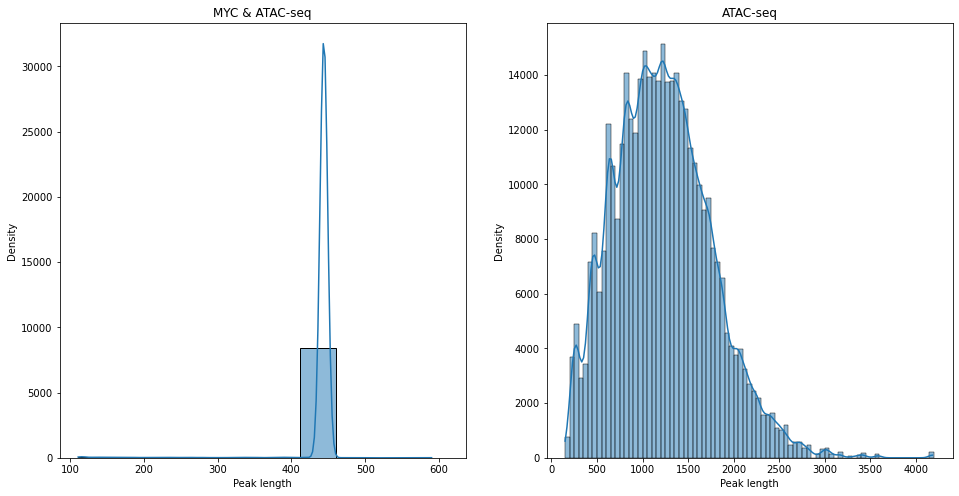

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for title, regions, ax in ("MYC & ATAC-seq", fg, axes[0]), ("ATAC-seq", bg, axes[1]):
  sns.histplot([x.length for x in regions], binwidth=50, kde=True, ax=ax)
  ax.set_title(title)
  ax.set_xlabel("Peak length")
  ax.set_ylabel("Density")

In [ ]:
from collections import Counter

Counter([x.length for x in fg])

* *Should we filter MYC-peaks somehow?* (2 points)

## Target sequences

In [ ]:
# Download the genome
!gsutil -m cp \
  "gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta" \
  "gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta.fai" \
  .

Copying gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta...
Copying gs://genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta.fai...
\ [2/2 files][  3.0 GiB/  3.0 GiB] 100% Done  49.0 MiB/s ETA 00:00:00           
Operation completed over 2 objects/3.0 GiB.                                      


In [ ]:
!head Homo_sapiens_assembly38.fasta

>chr1  AC:CM000663.2  gi:568336023  LN:248956422  rl:Chromosome  M5:6aef897c3d6ff0c78aff06ac189178dd  AS:GRCh38
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

* *What does 'N' mean?* (1 points)  
* *Why are there so many N's in the assembly?* (2 points)

In [ ]:
fasta = "Homo_sapiens_assembly38.fasta"

# Fetch target sequences from the genome
fgseq = fg.sequence(fi=fasta).seqfn
bgseq = bg.sequence(fi=fasta).seqfn

In [ ]:
!head fgseq

In [ ]:
!pip3 install biopython

In [ ]:
from Bio import SeqIO

fgseq = [str(x.seq) for x in SeqIO.parse(fgseq, format='fasta')]
bgseq = [str(x.seq) for x in SeqIO.parse(bgseq, format='fasta')]

We need to subsample ATAC-seq peaks to finish in a reasonable amount of time

In [ ]:
import numpy as np

print(f"fg: {len(fgseq)}; bg: {len(bgseq)}")

np.random.seed(123)
fgseq = np.random.choice(fgseq, size=8_000, replace=False)
bgseq = np.random.choice(bgseq, size=32_000, replace=False)

print(f"fg: {len(fgseq)}; bg: {len(bgseq)}")

fg: 8619; bg: 390672
fg: 8000; bg: 16000


* *Why can't we use raw sequences to train models directly?* (1 point)
* *What are K-mers?* (1 point)
* *Do you know any other approaches besides K-mers?* (0.5 point)

In [ ]:
from collections import defaultdict

def calculate_kmers(seq: str, klen: int):
  assert len(seq) >= klen and klen >= 1, seq
  total_kmers = len(seq) - klen + 1

  counts = defaultdict(int)
  for ind in range(total_kmers):
    window = seq[ind:ind+klen]
    counts[window] += 1
  frequencies = {k: v / total_kmers for k, v in counts.items()}
  return frequencies

In [ ]:
from tqdm import tqdm

KMERS = 1, 2, 3, 4, 5

df = []
for cls, sequences in (0, bgseq), (1, fgseq):
  for seq in tqdm(sequences):
    record = {}
    for klen in KMERS:
      record.update(calculate_kmers(seq, klen))
    record['Class'] = cls
    df.append(record)

100%|██████████| 8000/8000 [00:07<00:00, 1140.79it/s]


* *Why I used K-mers of size up to 5 and not 3 or 7?* (1 point)

In [ ]:
import pandas as pd

df = pd.DataFrame(df).fillna(0)
df.head()

A         C         G         T  ...  CCGNN  CGNNN  GNNNN  NNNNN
0  0.280958  0.195093  0.296729  0.227220  ...    0.0    0.0    0.0    0.0
1  0.181370  0.292755  0.303598  0.222277  ...    0.0    0.0    0.0    0.0
2  0.305720  0.221893  0.187377  0.285010  ...    0.0    0.0    0.0    0.0
3  0.204288  0.279950  0.298235  0.217528  ...    0.0    0.0    0.0    0.0
4  0.205905  0.242424  0.315462  0.236208  ...    0.0    0.0    0.0    0.0

[5 rows x 1395 columns]

In [ ]:
# Sanity check for labels
df['Class'].value_counts()

0    16000
1     8000
Name: Class, dtype: int64

In [ ]:
# Sanity check for dtypes
df.dtypes.value_counts()

float64    1394
int64         1
dtype: int64

In [ ]:
df.describe()

A             C  ...         GNNNN         NNNNN
count  24000.000000  24000.000000  ...  2.400000e+04  2.400000e+04
mean       0.221590      0.278221  ...  2.946723e-08  2.946723e-07
std        0.054335      0.057749  ...  4.565044e-06  4.565044e-05
min        0.015766      0.094595  ...  0.000000e+00  0.000000e+00
25%        0.180180      0.234234  ...  0.000000e+00  0.000000e+00
50%        0.218599      0.276195  ...  0.000000e+00  0.000000e+00
75%        0.260880      0.319017  ...  0.000000e+00  0.000000e+00
max        0.452703      0.529351  ...  7.072136e-04  7.072136e-03

[8 rows x 1395 columns]

## Train/Test split

In [ ]:
Y = df['Class'].values

tmp = df.drop(columns='Class')
features = tmp.columns.values
X = tmp.values

assert X.shape[1] == df.shape[1] - 1

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 123)

print("Train:")
print(f"\tX: {X_train.shape}; Y: {Y_train.shape}")
print("Test:")
print(f"\tX: {X_test.shape}; Y: {Y_test.shape}")

Train:
	X: (16800, 1394); Y: (16800,)
Test:
	X: (7200, 1394); Y: (7200,)


# Classification metrics

We will cover commonly used classification metrics using the following notation:  
* $TP$ - true positive predictions (REAL: true, PRED: true)
* $FP$ - false positive predictions (REAL: false, PRED: true)
* $TN$ - true negative predictions (REAL: false, PRED: false)
* $FN$ - false negative predictions (REAL: false, PRED: true)


*What (rows or columns) correspond to the target labels in the following table?* (1 point) 

|   | 0  | 1  |
|---|----|----|
| 0 | TN | FN |
| 1 | FP | TP |

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(class_weight='balanced')
logistic = logistic.fit(X_train, Y_train)

Y_true = Y_test
Y_prob = logistic.predict_proba(X_test)

In [ ]:
print(Y_prob[:5])
Y_prob = Y_prob[:, 1]

[[0.52943048 0.47056952]
 [0.55177417 0.44822583]
 [0.76846748 0.23153252]
 [0.70500014 0.29499986]
 [0.69239694 0.30760306]]


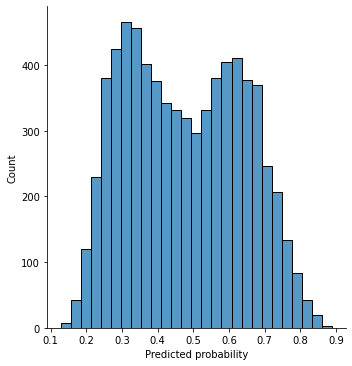

In [ ]:
sns.displot(Y_prob)
_ = plt.xlabel("Predicted probability")

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

Y_pred = Y_prob > threshold

matrix = confusion_matrix(Y_true, Y_pred)
matrix

array([[3169, 1596],
       [ 787, 1648]])

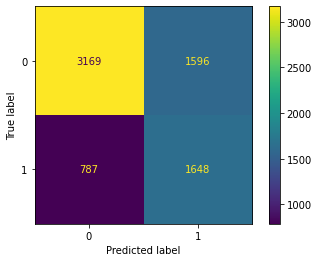

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=matrix).plot()
plt.show()

## Accuracy

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

In [ ]:
from sklearn.metrics import accuracy_score
threshold = 0.5

Y_pred = Y_prob > threshold
correct = Y_true[Y_pred].sum() + (1 - Y_true)[~Y_pred].sum()
accuracy = correct / len(Y_true) 
print(f"Accuracy: {accuracy: .3f}")

print(f"sklearn accuracy: {accuracy_score(Y_true, Y_pred): .3f}")

Accuracy:  0.669
sklearn accuracy:  0.669


## Precision

$$Precision=\frac{TP}{TP+FP}$$

In [ ]:
from sklearn.metrics import precision_score
threshold = 0.35

Y_pred = Y_prob > threshold
precision = Y_true[Y_pred].sum() / Y_pred.sum()
print(f"Precision(fg class): {precision: .3f}")

print(f"sklearn precision(bg class): {precision_score(Y_true, Y_pred, pos_label=0): .3f}")
print(f"sklearn precision(fg class): {precision_score(Y_true, Y_pred, pos_label=1): .3f}")

Precision(fg class):  0.427
sklearn precision(bg class):  0.882
sklearn precision(fg class):  0.427


## Recall
$$Recall = \frac{TP}{TP+FN}$$

In [ ]:
from sklearn.metrics import recall_score
threshold = 0.35

Y_pred = Y_prob > threshold
recall = Y_true[Y_pred].sum() / Y_true.sum()
print(f"Recall(fg class): {recall: .3f}")

print(f"sklearn recall(bg class): {recall_score(Y_true, Y_pred, pos_label=0): .3f}")
print(f"sklearn recall(fg class): {recall_score(Y_true, Y_pred, pos_label=1): .3f}")

Recall(fg class):  0.899
sklearn recall(bg class):  0.383
sklearn recall(fg class):  0.899


## F1 score

$$F_1=2*\frac{Precision*Recall}{Precision + Recall}=\frac{2TP}{2TP + FP + FN}$$

Harmonic mean of precision and recall

In [ ]:
from sklearn.metrics import f1_score
threshold = 0.35

Y_pred = Y_prob > threshold

precision = precision_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 score(fg class): {f1: .4f}")

f1 = f1_score(Y_true, Y_pred)
print(f"sklearn recall(fg class): {f1: .4f}")

F1 score(fg class):  0.5789
sklearn recall(fg class):  0.5789


## Precision-Recall curve

(0.0, 1.0)

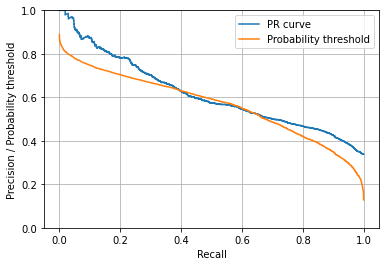

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(Y_true, Y_prob)

plt.plot(recall, precision, label="PR curve")
plt.plot(recall[:-1], thresholds, label="Probability threshold")
plt.grid()
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision / Probability threshold")
plt.ylim(0, 1)

In [ ]:
from sklearn.metrics import average_precision_score
print("AP(PR AUC): ", average_precision_score(Y_true, Y_prob))

AP(PR AUC):  0.6162540575488796


(0.0, 1.0)

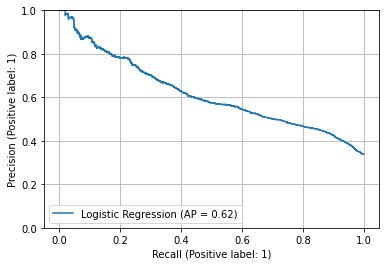

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
prc = PrecisionRecallDisplay.from_predictions(Y_true, Y_prob, name='Logistic Regression')
plt.grid()
plt.ylim(0, 1)

## Receiver Operating Characteristic (ROC) curve

$$TPR = P(True|True) = \frac{TP}{TP + FN}$$
$$FPR = P(False|True) = \frac{FP}{FP + TN}$$



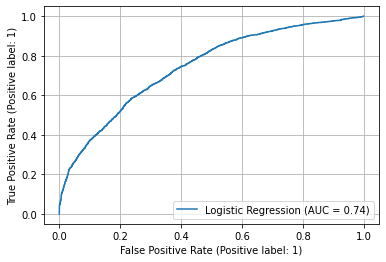

In [ ]:
from sklearn.metrics import RocCurveDisplay

prc = RocCurveDisplay.from_predictions(Y_true, Y_prob, name='Logistic Regression')
plt.grid()

In [ ]:
from sklearn.metrics import roc_auc_score
print(f"ROC AUC: {roc_auc_score(Y_true, Y_prob)}")

ROC AUC: 0.7431522200508067


## Classification Report

In [ ]:
from sklearn.metrics import classification_report

threshold = 0.75
Y_pred = Y_prob > threshold

print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      4765
           1       0.88      0.10      0.17      2435

    accuracy                           0.69      7200
   macro avg       0.78      0.54      0.49      7200
weighted avg       0.75      0.69      0.59      7200



# Utils

In [ ]:
def report(model, X_test, Y_test, threshold=0.5):
  Y_prob = model.predict_proba(X_test)[:, 1]
  Y_pred = Y_prob > threshold
  print(f"F-measure: {f1_score(Y_test, Y_pred):.3f}")
  print(f"ROC AUC: {roc_auc_score(Y_test, Y_prob):.3f}")
  print(f"PR AUC: {average_precision_score(Y_test, Y_prob):.3f}")


# Decision Trees

![](https://bookdown.org/tpinto_home/Beyond-Additivity/tree.png)

The main parameters of the [`sklearn.tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class:

- `max_depth` – the maximum depth of the tree
- `max_features` - the maximum number of features to search for the best partition (this is necessary because with a large number of variables it'll be "expensive" to look for the best (according to the information gain-type criterion) partition among *all* variables)
- `min_samples_leaf` – the minimum number of objects in a leaf.This parameter has a clear interpretation: for example, if it is equal to 5, the tree will produce only those classifying rules that are true for at least 5 objects

The parameters of tree need to be set depending on the input data, and it is usually done with the help of *cross-validation*.

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(max_depth=10, random_state=17).fit(X_train, Y_train)

In [ ]:
features = df.drop(columns=["Class"]).columns.values
export_graphviz(tree, 'tree.dot', filled=True, feature_names=features)

!dot -Tpng tree.dot -o tree.png -Gdpi=400

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.80398 to fit


In [ ]:
from IPython.display import Image
Image('tree.png')

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {
    'max_depth': [3, 6, 9, 12],
    'class_weight': [None, 'balanced'],
    'min_samples_leaf': [100]
}

grid = GridSearchCV(
    DecisionTreeClassifier(), grid, cv=3, scoring='f1_macro'
) 

grid.fit(X_train, Y_train)
print("Best params:", grid.best_params_)
print("Best cross validaton score", grid.best_score_)

Best params: {'class_weight': None, 'max_depth': 12, 'min_samples_leaf': 100}
Best cross validaton score 0.9462184186239866


In [ ]:
tree = grid.best_estimator_
print("Test")
report(tree, X_test, Y_test)

Test
F-measure: 0.940
ROC AUC: 0.994
PR AUC: 0.987
Train
F-measure: 0.947
ROC AUC: 0.996
PR AUC: 0.992


In [ ]:
print("Train")
report(tree, X_train, Y_train)

## Feature importance

Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node.

In [ ]:
importance = pd.DataFrame(
    tree.feature_importances_, index=features, columns=['Importance']
).sort_values(by='Importance', ascending=False)
importance.head()

Importance
ACGTG    0.328108
CTCTA    0.201853
TCTA     0.128669
TTCTA    0.101018
GTCTA    0.087230

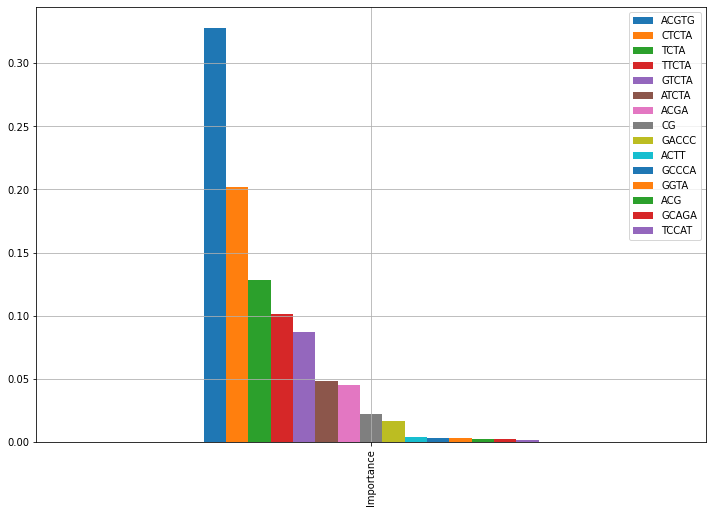

In [ ]:
plt.figure(figsize=(12, 8))
importance.iloc[:15].T.plot.bar(ax=plt.gca())
plt.grid()

# Random Forest

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=50, n_jobs=-1, 
    class_weight='balanced_subsample'
).fit(X_train, Y_train)

In [ ]:
report(forest, X_test, Y_test)

F-measure: 0.911
ROC AUC: 0.988
PR AUC: 0.976


In [ ]:
importance = pd.DataFrame(
    forest.feature_importances_, index=features, columns=['Importance']
).sort_values(by='Importance', ascending=False)
importance.head()

Importance
ACGT     0.026049
ACAGT    0.021598
TATA     0.019962
TTAT     0.018917
ACGTG    0.018853

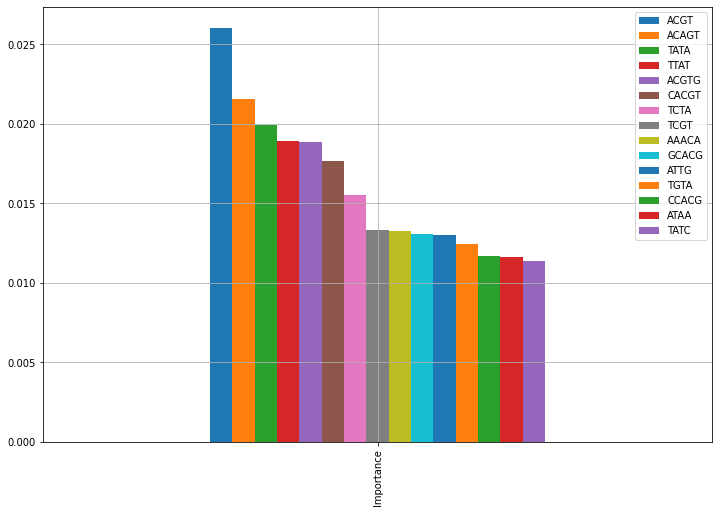

In [ ]:
plt.figure(figsize=(12, 8))
importance.iloc[:15].T.plot.bar(ax=plt.gca())
plt.grid()

# Gradient boosting

In [ ]:
import xgboost
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(n_estimators=100, random_state=42)  
xgb.fit(X_train, Y_train)  

XGBClassifier(random_state=42)

In [ ]:
report(xgb, X_test, Y_test)

F-measure: 0.992
ROC AUC: 1.000
PR AUC: 0.999


https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance

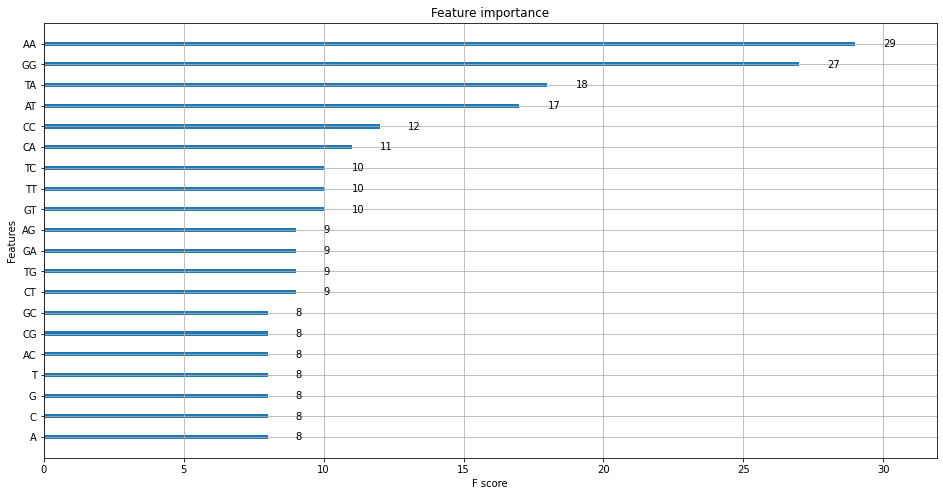

In [ ]:
n = 20

plt.figure(figsize=(16, 8))
_ = xgboost.plot_importance(xgb, max_num_features=n, ax = plt.gca())\
           .set_yticklabels(features[:n])